In [1]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from cliffs_delta import cliffs_delta

from ecoselekt.settings import settings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
EXP_ID = "apch"
MODEL_HISTORY = 15

PROJECTS = [
    "activemq",
    "camel",
    "cassandra",
    "flink",
    "groovy",
    "hbase",
    "hive",
    "ignite",
]

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
all_latency_df = pd.DataFrame(columns=["project", "window", "commit_id", "eco_pred_time", "base_pred_time"])
for project in PROJECTS:
    latency_df = pd.read_csv(DATA_DIR / f"{EXP_ID}_{project}_inf_perf_lr.csv")
    latency_df["project"] = project
    all_latency_df = pd.concat([all_latency_df, latency_df], ignore_index=True)

all_latency_df["eco_pred_time"] = all_latency_df["eco_pred_time"] * 1000
all_latency_df["base_pred_time"] = all_latency_df["base_pred_time"] * 1000

all_latency_df.head()

,project,window,commit_id,eco_pred_time,base_pred_time
0,activemq,15,014773936022e72b4f8fdff90a0f9fdc33c9b247,53.965092,2.183914
1,activemq,15,02538ed9061b1a57c1a8b0c5accff76465429da0,36.906004,2.694845
2,activemq,15,02ef3dc91846b209dbcf9b65cced501bda2d8280,32.788038,1.838684
3,activemq,15,0484af1c61ca26ce8ea7e2decf953052e0a7ad1e,49.112082,2.902031
4,activemq,15,093b0e2370ebd4c133fa2f110a39ac53dd1bb699,35.587072,1.976252


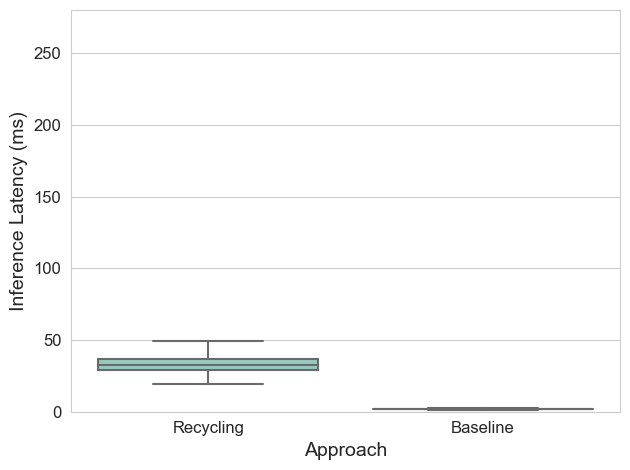

In [4]:
# plot boxplot of inference latency for both eco and base models in one plot
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(all_latency_df[["eco_pred_time", "base_pred_time"]].rename(columns={"eco_pred_time": "Recycling", "base_pred_time": "Baseline"})),
    palette="Set3",
    showfliers=False,
)
# start from 0 y-axis
p.set_ylim(0, 280)
# increase font size
p.tick_params(labelsize=12)
p.set_xlabel("Approach", fontsize=14)
p.set_ylabel("Inference Latency (ms)", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
ALPHA = 0.05

stat_df = pd.DataFrame(columns=["project", "significant", "effect_size"])

for project in PROJECTS:
    temp_df = all_latency_df[all_latency_df["project"] == project]
    _, p = wilcoxon(temp_df["eco_pred_time"], temp_df["base_pred_time"])
    print(f"Significant? -> {p < ALPHA}")
    res = None
    if p < ALPHA:
        d, res = cliffs_delta(temp_df["eco_pred_time"], temp_df["base_pred_time"])
        print(f"Cliff's Delta -> {d}, {res}")
    eco_med = temp_df["eco_pred_time"].median()
    base_med = temp_df["base_pred_time"].median()
    factor = eco_med / base_med
    print(f"Median factor -> {factor}")
    stat_df = stat_df.append({"project": project, "significant": p, "effect_size": res, "eco_med": eco_med, "base_med": base_med, "factor": factor}, ignore_index=True)

stat_df

Significant? -> True
Cliff's Delta -> 1.0, large
Median factor -> 16.408683579452898
Significant? -> True
Cliff's Delta -> 0.999999505723205, large
Median factor -> 17.811474390850925
Significant? -> True
Cliff's Delta -> 1.0, large
Median factor -> 15.245969742063465
Significant? -> True
Cliff's Delta -> 0.9984008137119114, large
Median factor -> 16.93545229754837
Significant? -> True
Cliff's Delta -> 0.9997545, large
Median factor -> 16.052228214589913
Significant? -> True
Cliff's Delta -> 1.0, large
Median factor -> 15.565818519809808
Significant? -> True
Cliff's Delta -> 1.0, large
Median factor -> 12.900065710218314
Significant? -> True
Cliff's Delta -> 0.99976728125, large
Median factor -> 17.01467865644022


,project,significant,effect_size,eco_med,base_med,factor
0,activemq,0.0,large,30.995846,1.888990,16.408684
1,camel,0.0,large,34.159541,1.917839,17.811474
2,cassandra,0.0,large,29.312015,1.922607,15.245970
3,flink,0.0,large,39.190173,2.314091,16.935452
4,groovy,0.0,large,26.966095,1.679897,16.052228
5,hbase,0.0,large,31.942129,2.052069,15.565819
6,hive,0.0,large,28.083444,2.177000,12.900066
7,ignite,0.0,large,30.676126,1.802921,17.014679


In [6]:
print(stat_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrlrrr}
\toprule
  project &  significant & effect\_size &  eco\_med &  base\_med &  factor \\
\midrule
 activemq &        0.000 &       large &   30.996 &     1.889 &  16.409 \\
    camel &        0.000 &       large &   34.160 &     1.918 &  17.811 \\
cassandra &        0.000 &       large &   29.312 &     1.923 &  15.246 \\
    flink &        0.000 &       large &   39.190 &     2.314 &  16.935 \\
   groovy &        0.000 &       large &   26.966 &     1.680 &  16.052 \\
    hbase &        0.000 &       large &   31.942 &     2.052 &  15.566 \\
     hive &        0.000 &       large &   28.083 &     2.177 &  12.900 \\
   ignite &        0.000 &       large &   30.676 &     1.803 &  17.015 \\
\bottomrule
\end{tabular}

